In [1]:
using MAT
using Glob
using PyCall
using PyPlot
using Random
using Eirene
using Statistics
using Distributions
using DelimitedFiles

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-8015535341968266285\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4228586298847470537\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-8015535341968266285\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function generate_complete_sorting(num_red, num_green, num_r_cluster, num_g_cluster, seed)
    
    Random.seed!(seed);
    
    # place 'red' labelled cells
    amountpercluster = [];
    cellsleft = num_red
    cluster_size_sigma = 0.5
    for j in 1:(num_r_cluster - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);
        end
        push!(amountpercluster,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountpercluster, cellsleft)
    redcellpos = Array{Float64}(undef, 0, 2);
    celltypes = ones(num_red,1);
    for i in 1:num_r_cluster
        clustercenter = rand(Uniform(-8,8), 1, 2);
        sigma = rand(Uniform(0.1, cluster_size_sigma), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountpercluster[i]));
        redcellpos = vcat(redcellpos,clustercells);
    end
    
    # place 'green' labelled cells
    amountperclusterg = [];
    cellsleft = num_green
    for j in 1:(num_g_cluster - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);            
        end

        push!(amountperclusterg,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountperclusterg, cellsleft)
    greencellpos = Array{Float64}(undef, 0, 2)

    for i in 1:num_g_cluster
        clustercenter = rand(Uniform(-8,8), 1, 2);
        sigma = rand(Uniform(0.1, cluster_size_sigma), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells = transpose(rand(distribution,amountperclusterg[i]));
        greencellpos = vcat(greencellpos,clustercells);
    end  
    cellpos = vcat(redcellpos,greencellpos);
    celltypes = vcat(celltypes, (ones(num_green,1)+ones(num_green,1)));
    
    posfile = matopen("complete_sorting_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("complete_sorting_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes);
    
end

function generate_engulfment(num_red, num_green, num_green_clusters, seed)
    
    # 'red' cells are engulfed by green cells
    Random.seed!(seed);
    
    amountpercluster = [];
    largeclustercenter = rand(Uniform(-5, 5), 1, 2);
    largeclustersigma = rand(Uniform(2, 3), 1, 2);
    
    cellsleft = num_green;
    for j in 1:(num_green_clusters - 1)
        amounttaken = 0;
        if(cellsleft != 0)
            amounttaken = rand(1:cellsleft);
        end
        push!(amountpercluster,amounttaken);
        cellsleft  = cellsleft - amounttaken;
    end
    push!(amountpercluster, cellsleft)
    greencellpos = Array{Float64}(undef, 0, 2);
    celltypes = ones(num_green,1);
    for i in 1:num_green_clusters
        # restrict cluster center within larger 'green' cell cluster
        clustercenter = [rand(Uniform(largeclustercenter[1] - largeclustersigma[1], 
                    largeclustercenter[1] + largeclustersigma[1])), 
            rand(Uniform(largeclustercenter[2] - largeclustersigma[2],
                    largeclustercenter[2] + largeclustersigma[2]))];
        sigma = rand(Uniform(0.1, 0.5), 1, 2);
        distribution = MvNormal(vec(clustercenter),vec(sigma));
        clustercells =rand(distribution,amountpercluster[i]);
        clustercells = transpose(clustercells);
        greencellpos = vcat(greencellpos,clustercells);
    end
    
    redcellpos = Array{Float64}(undef, 0, 2);
    maindistribution = MvNormal(vec(largeclustercenter),vec(largeclustersigma));
    k = 1;
    while (k <=num_red)
        redcell = transpose(rand(maindistribution,1));
        isincluster = false;
        for l in 1:num_green
            dist = ((redcell[1] - greencellpos[l,1])^2 + (redcell[2] - greencellpos[l,2])^2)^0.5;
            if(dist<=0.001)
                isincluster = true;
            else
                isincluster = false;
            end
        end
        if (!isincluster)
            redcellpos = vcat(redcellpos,redcell);
            
        else
            k -= 1;
        end
        k += 1;
    end
    
    cellpos = vcat(redcellpos,greencellpos);
    celltypes = ones(num_red,1);
    celltypes = vcat(celltypes, (ones(num_green,1)+ones(num_green,1)));
    
    posfile = matopen("engulfment_pos.mat", "w");
    write(posfile, "positions", cellpos)
    close(posfile)
    
    typefile = matopen("engulfment_types.mat", "w");
    write(typefile, "types", celltypes)
    close(typefile)
    
    return (cellpos, celltypes);
    
end

function plot_syn_data(cell_pos, cell_type)
    
    figure(figsize=(5,5), dpi=200)
    num_cells = size(cell_type)[1]
    for cid in range(1, stop=num_cells)
        if cell_type[cid] == 1.0
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="red")
        elseif cell_type[cid] == 2
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="green")
        else
            scatter(cell_pos[cid,1], cell_pos[cid,2], color="blue")
            write(stderr, "WARNING: More than 2 cell types")
        end                
    end
    xlim([-10, 10])
    ylim([-10, 10])
    xticks([])
    yticks([])
    
end;

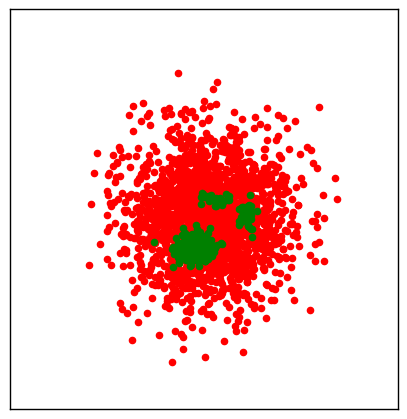

In [3]:
cellpos, celltypes = generate_engulfment(2000, 400, 3, 42)
plot_syn_data(cellpos, celltypes);

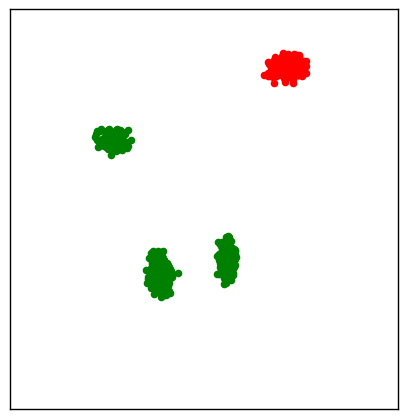

In [4]:
(cell_pos, cell_types) = generate_complete_sorting(500, 1000, 1, 3, 123)
plot_syn_data(cell_pos, cell_types);